In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot params
plt.style.use('seaborn');
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("tab10")

In [98]:
def sigmoid(x, b=0.0,k=0.05):
    # sigmoid function
    # use k to adjust the slope
    s = 1 / (1 + np.exp((x-b)/k)) 
    return s

Text(0.5, 0, 'Cossim(sim, abs)')

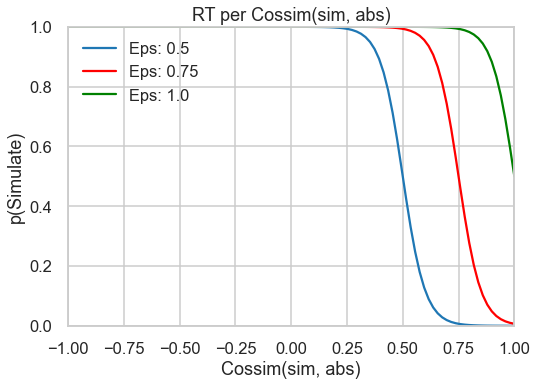

In [104]:
# un-normalised data
x = np.linspace(-1,+1,100)
g=sns.lineplot(x=x, y=sigmoid(x,b=0.5),label="Eps: 0.5")
sns.lineplot(x=x, y=sigmoid(x,b=0.75), color='red',label="Eps: 0.75")
sns.lineplot(x=x, y=sigmoid(x,b=1.0), color='green',label="Eps: 1.0")
g.set(xlim=(-1, 1),ylim=(0,1))
plt.title("RT per Cossim(sim, abs)")
plt.ylabel("p(Simulate)")
plt.xlabel("Cossim(sim, abs)")